In [1]:
import numpy as np
from torch.utils.data import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

class LorentzDataset(Dataset):
    def __init__(self, data, train=True, split_idx=1200):
        super(LorentzDataset, self).__init__()
        self.v = data[:, :2] #v1, v2 -> p
        self.x = data[:, 2:] #x1, x2 -> q

        #split the dataset based on split_idx, we use 1200 as defined within the problem
        if train:
            self.v = self.v[:split_idx]
            self.x = self.x[:split_idx]
        else:
            self.v = self.v[split_idx:]
            self.x = self.x[split_idx:]

    def __len__(self):
        return len(self.v) - 1

    def __getitem__(self, idx):
        curr_state = torch.FloatTensor(np.concatenate([self.v[idx], self.x[idx]])) #FloatTensor -> 32b fp32
        next_state = torch.FloatTensor(np.concatenate([self.v[idx+1], self.x[idx+1]]))

        return curr_state, next_state

In [2]:
#load in data -> v1, v2, x1, x2
data = np.loadtxt('data_lorentz/train.txt')

#split/setup data (1200 vs. 300)
train_dataset = LorentzDataset(data, train=True)
test_dataset = LorentzDataset(data, train=False)

batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Define the physics used for the PINN:

In [ ]:
#physics helper functions
def scalar_potential(x):
    x1, x2 = x[:, 0], x[:, 1]
    return 1 / (100 * torch.sqrt(x1**2 + x2**2))

def vector_potential(x):
    x1, x2 = x[:, 0], x[:, 1]
    return torch.stack([
        -x2 * torch.sqrt(x1**2 + x2**2) / 3,
         x1 * torch.sqrt(x1**2 + x2**2) / 3,
        torch.zeros_like(x1)
    ], dim=1)

def magnetic_field(x):
    x1, x2 = x[:, 0], x[:, 1]
    return torch.stack([
        torch.zeros_like(x1),
        torch.zeros_like(x1),
        torch.sqrt(x1**2 + x2**2)
    ], dim=1)

def B_hat(x):
    B = magnetic_field(x)
    B3 = B[:, 2]
    zero = torch.zeros_like(B3)
    return torch.stack([
        torch.stack([zero, -B3], dim=1),
        torch.stack([B3, zero], dim=1)
    ], dim=1)

def hamiltonian(v, x, m=1.0, q=1.0):
    kinetic = 0.5 * torch.sum(v**2, dim=1)
    potential = (q / m) * scalar_potential(x)
    A = vector_potential(x)[:, :2] #ignore x3
    magnetic_coupling = q * torch.sum(v * A, dim=1)
    return kinetic + potential + magnetic_coupling

def physics_loss(model, x):
    x.requires_grad_(True)
    output = model(x)
    v = output[:, :2]
    x_pos = output[:, 2:]
    H = hamiltonian(v, x_pos, model.m, model.q)
    
    grad_H_v = torch.autograd.grad(H.sum(), v, create_graph=True)[0]
    grad_H_x = torch.autograd.grad(H.sum(), x_pos, create_graph=True)[0]
    
    dvdt = torch.autograd.grad(v.sum(), x, create_graph=True)[0][:, :2]
    dxdt = torch.autograd.grad(x_pos.sum(), x, create_graph=True)[0][:, 2:]
    
    B = magnetic_field(x_pos)
    B_hat_matrix = B_hat(x_pos) #batch, 2, 2
    magnetic_term = (model.q / model.m) * torch.bmm(B_hat_matrix, grad_H_v.unsqueeze(-1)).squeeze()
    
    loss_dvdt = dvdt + magnetic_term + grad_H_x
    loss_dxdt = dxdt - grad_H_v
    physics_loss = torch.mean(loss_dvdt**2) + torch.mean(loss_dxdt**2)
    return physics_loss

Define the PINN's architecture:

In [4]:
class PINN(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=100, output_dim=4):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )
        
        #learnable parameters, mass and charge (defined to be 1 within the problem statement, so we set our initial guess to match)
        self.m = nn.Parameter(torch.tensor(1.0))
        self.q = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, x):
        return self.net(x)

Train the PINN:

In [5]:
model = PINN(input_dim=4, output_dim=4)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0000005) #0.000001
lambda_data = 1000

num_epochs = 230 #175
train_losses = []
test_losses = []
predicted_m = []
predicted_q = []

epoch = 0
train_loss = 0
test_loss = 0

pbar = tqdm(range(num_epochs), desc=f'Epoch {epoch}, train loss: {train_loss}, test loss: {test_loss}')

for epoch in pbar:
    model.train()
    tot_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()

        outputs = model(inputs)
        data_loss = criterion(outputs, targets)

        p_loss = physics_loss(model, inputs)

        loss = lambda_data * data_loss + p_loss
            
        loss.backward()
        optimizer.step()
            
        tot_loss += loss.item()
    
    train_loss = tot_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            test_loss += criterion(outputs, targets).item()

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)

    #append mass and charge predictions
    predicted_m.append(model.m.item())
    predicted_q.append(model.q.item())

    pbar.set_description(f"Epoch {epoch+1} | Train: {train_loss} | Test: {test_loss} | m: {model.m.item()} | q: {model.q.item()}")

pbar.close()

Epoch 230 | Train: 3.8977081331737446 | Test: 0.001762018746729118 | m: 1.022720217704773 | q: 0.9739888310432434: 100%|██████████| 230/230 [19:59<00:00,  5.22s/it]  


Visualize the PINN's loss:

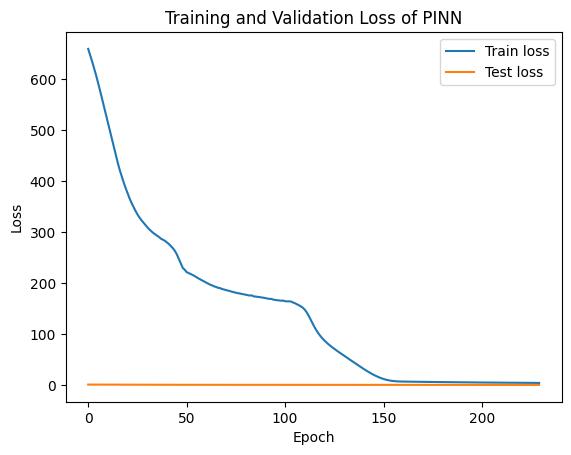

In [15]:
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss of PINN")
plt.legend()

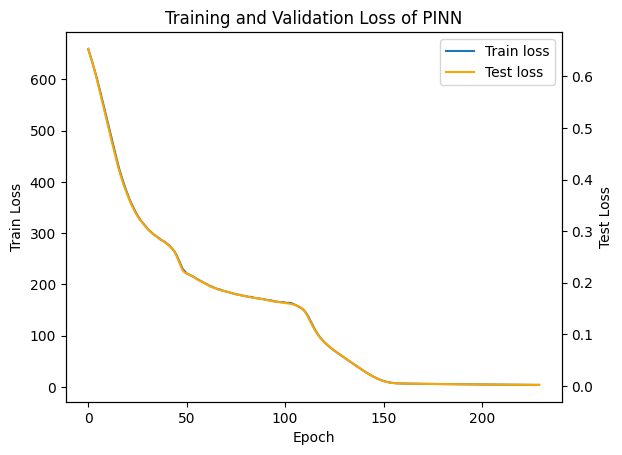

In [16]:
#plot with different axes because of the lambda_data term
fig, ax1 = plt.subplots()

# Plot train loss on left axis (ax1)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss')
ax1.plot(train_losses, label="Train loss")
ax1.tick_params(axis='y')

#same x
ax2 = ax1.twinx()

ax2.set_ylabel('Test Loss')
ax2.plot(test_losses, label="Test loss", c='orange')
ax2.tick_params(axis='y')

plt.title("Training and Validation Loss of PINN")

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

plt.show()

Visualize q/m predictions:

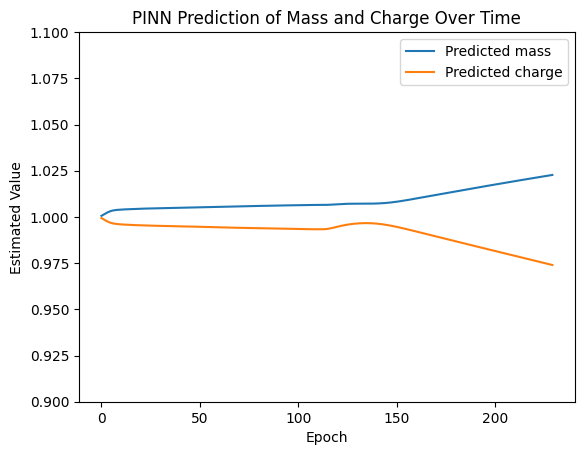

In [17]:
plt.plot(predicted_m, label="Predicted mass")
plt.plot(predicted_q, label="Predicted charge")
plt.xlabel("Epoch")
plt.ylabel("Estimated Value")
plt.title("PINN Prediction of Mass and Charge Over Time")
plt.ylim(0.9, 1.1)
plt.legend()

In [18]:
final_predicted_m = model.m.item()
final_predicted_q = model.q.item()
print(f"Final m: {final_predicted_m}, final q: {final_predicted_q}")

Final m: 1.022720217704773, final q: 0.9739888310432434


Define the numerical integrator (Crank-Nicolson):

In [19]:
def compute_state_derivatives(state, m, q):
    state = state.clone().requires_grad_(True)
    v = state[:, :2] #v1, v2
    x = state[:, 2:] #x1, x2

    H = 0.5*m*(v**2).sum(dim= 1) + q*(0.01*torch.sqrt((x**2).sum(dim=1)))

    grad_v, grad_x = torch.autograd.grad(H.sum(), (v, x), create_graph=False)

    B3 = torch.sqrt((x**2).sum(dim=1))
    term1 = (-q/m)*torch.stack([-B3*grad_v[:,1], B3*grad_v[:,0]], dim=1)
    term2 = (-1/m)*grad_x
    dv_dt = term1 + term2
    dx_dt = v
    return torch.cat([dv_dt, dx_dt], dim=1)

In [20]:
def crank_nicolson_traj(s0, dt, m, q, steps, picard_iters=10):
    traj = [s0]
    s_n = s0

    for i in range(steps):
        k1 = compute_state_derivatives(s_n, m, q)
        
        s_np1 = s_n + dt*k1
        
        for j in range(picard_iters):
            k2 = compute_state_derivatives(s_np1, m, q)
            s_np1 = s_n + 0.5*dt*(k1 + k2)
        traj.append(s_np1)
        s_n = s_np1.detach()
    return torch.stack(traj)

Extrapolate in time using the predicted mass and charge:

In [21]:
test_dataset = torch.from_numpy(data[1200:]).float() #1201 on

s0 = test_dataset[0:1]
steps = len(test_dataset) - 1
pred_traj = crank_nicolson_traj(s0, 0.1, final_predicted_m, final_predicted_q, steps).squeeze(1).detach().numpy()

Text(0.5, 1.0, 'Trajectory of Particle Over Time')

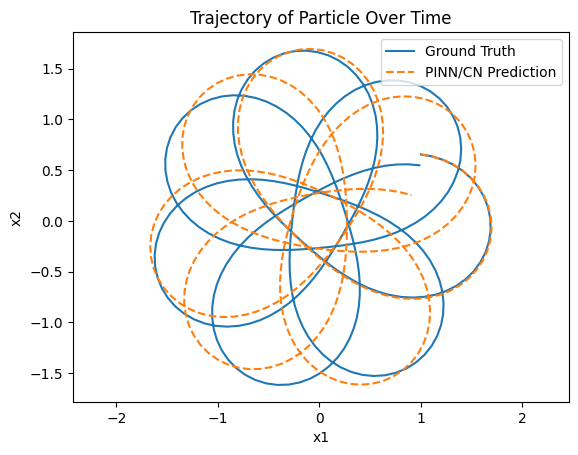

In [22]:
test_predictions_v = pred_traj[:, :2] #v1, v2
test_predictions_x = pred_traj[:, 2:] #x1, x2

test_targets_v = test_dataset[:, :2].numpy()
test_targets_x = test_dataset[:, 2:].numpy()

plt.plot(test_targets_x[:, 0], test_targets_x[:, 1], label="Ground Truth")
plt.plot(test_predictions_x[:, 0], test_predictions_x[:, 1], label="PINN/CN Prediction", linestyle='--')
plt.legend()
plt.axis("equal")
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Trajectory of Particle Over Time")

Calculate/visualize MSE:

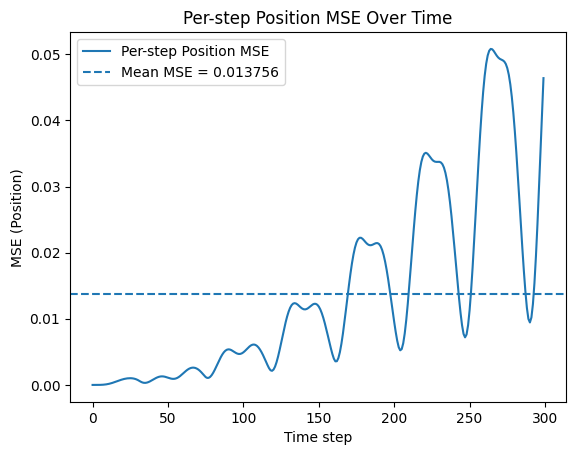

In [23]:
mse_per_step_velocity = np.mean((test_targets_v - test_predictions_v)**2, axis=1)
mse_per_step_position = np.mean((test_targets_x - test_predictions_x)**2, axis=1)
tot_velocity_mse = np.mean(mse_per_step_velocity)
tot_position_mse = np.mean(mse_per_step_position)

plt.plot(np.arange(len(mse_per_step_position)), mse_per_step_position, label='Per-step Position MSE')
plt.axhline(y=tot_position_mse, linestyle='--', label=f'Mean MSE = {tot_position_mse:.6f}')
plt.xlabel('Time step')
plt.ylabel('MSE (Position)')
plt.title('Per-step Position MSE Over Time')
plt.legend()

loss_data = pd.DataFrame({
    "time_step": np.arange(len(mse_per_step_position)),
    "mse_per_step_position": mse_per_step_position,
})

loss_data.to_csv('mse_position_pinn.csv', index=False)